In [1]:
import torch as th
from torch import nn
from torch.nn import ModuleList
import numpy as np
import math
from einops import reduce, rearrange, einsum
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
from transformers import AutoTokenizer, pipeline

In [34]:
import pandas as pd
import time
from matplotlib import pyplot as plt

In [4]:
file = open("data/Harry_Potter.txt", 'r')
content = file.read()

In [5]:
len(content)

442745

In [6]:
device = th.device("cuda")
device

device(type='cuda')

In [7]:
"""
Takes in the text file, the length of the sequence to return.
returns the token ids using the passed tokenizer.
"""

class TextData(Dataset):
    def __init__(self, data, seq_len, tokenizer, device):
        super().__init__()
        self.data = data
        self.device = device
        self.seq_len = seq_len
        self.num_seq = len(self.data)//self.seq_len
        #split the text file into batch of texts of seq_len size
        self.data = [self.data[i:i+self.seq_len] for i in range(0, len(self.data), self.seq_len)]
        
        self.data = tokenizer(self.data, padding=True, truncation=True, return_tensors='pt')
    def __len__(self):
        return self.num_seq
    def __getitem__(self, idx):
        return self.data["input_ids"][idx].to(self.device)

In [8]:
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, inp, target):
        loss = F.log_softmax(inp, dim=-1)
        loss = -loss.gather(dim=-1, index=target.unsqueeze(dim=-1))
        return loss.mean()

In [9]:
"""
After each block, the token tensor is normalized along it's dimension.
The normalization itself is a learnable module.
"""

class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1.e-5):
        super().__init__()
        self.dim = dim
        self.w = nn.Parameter(th.ones(self.dim))
        self.b = nn.Parameter(th.zeros(self.dim))
        self.eps = eps
    def forward(self, x):
        #mean and standard deviation along the dimension of token vector
        mean = x.mean(dim=-1, keepdim=True)
        std = (x.var(dim=-1, keepdim=True, unbiased=False) + self.eps).sqrt()
        return self.w*(x - mean)/std + self.b

In [10]:
"""
Embedding block consists of a lookup matrix.
The matrix consists of embedding vector for each token in the vocabulary
"""

class Embedding(nn.Module):
    def __init__(self, vocab_dim, embed_dim):
        super().__init__()
        self.vocab_dim = vocab_dim
        self.embed_dim = embed_dim
        self.embedding = nn.Parameter(th.empty(self.vocab_dim, self.embed_dim))
        nn.init.normal_(self.embedding, std=1.)
    def forward(self, tokens):
        return self.embedding[tokens-1]

In [11]:
"""
The positional embedding is calculated for once for the maximum context size and stored as a buffer.
Each token in the sequence is assigned an array of sequence of values of sine and cosine. The positional embedding adds to the input tensor.
"""

class PosEncoding(nn.Module):
    def __init__(self, dim, max_seq_len):
        super().__init__()
        #timestamp for each token
        t = th.arange(max_seq_len).reshape(-1,1)
        #each timestamp has a dimension which contains sequence of sine and cosine values
        se = th.arange(0, dim, 2).reshape(1,-1)
        ce = th.arange(0, dim if dim%2==0 else dim-1, 2).reshape(1,-1)
        se = th.exp(-8*se*math.log(10)/dim)
        ce = th.exp(-8*ce*math.log(10)/dim)
        se = (t*se).sin()
        ce = (t*ce).cos()
        encoding = th.zeros(max_seq_len, dim)
        #the sine and cosine sequence of values are interleaved together
        encoding[:,0::2] = se
        encoding[:,1::2] = ce
        self.register_buffer("encoding", encoding)
    def forward(self, x):
        #x.shape = (batch_size, seq_len, dim)
        seq_len = x.shape[1]
        return x + self.encoding[:seq_len,:]

In [12]:
'''
Takes the batched input of sequence of vectors of shape (batch_size, seq_len, embed_dim).
Each head independently calculates the masked attention pattern for the batch of sequence.
The output vector is weighted according to the attention patterns.
The output sequence of vectors are concatenated along the vector dimension.
The concatenated sequence of vectors are linear transformed to produce the output.
'''
class Attention(th.nn.Module):
    def __init__(self, num_heads, res_dim):
        super().__init__()
        self.num_heads = num_heads
        self.res_dim = res_dim
        assert self.res_dim%self.num_heads == 0
        self.head_dim = self.res_dim//self.num_heads
        self.scale = 1/math.sqrt(self.head_dim)
        self.layer_norm = LayerNorm(self.res_dim)
        #define a linear layer that map to three times the residual dimension
        #the resulting vector produced will be the concatenation of query, key and value vectors
        self.QKV = th.nn.Linear(self.res_dim, 3*self.res_dim)
        #the concatenated output from heads will be transformed using this
        self.O = th.nn.Linear(self.res_dim, self.res_dim)
    def forward(self, x):
        #x.shape = (batch_size, seq_len, res_dim)
        #q,k,v.shape = (batch_size, num_heads, seq_len, head_dim)
        x = self.layer_norm(x)
        q, k, v = rearrange(self.QKV(x), 'b s (qkv h d) -> qkv b h s d', qkv=3, h=self.num_heads, d=self.head_dim)
        attn_patterns = self.attnPatterns(q, k)
        weighted_v = self.weightedValues(attn_patterns, v)
        output_v = rearrange(weighted_v, 'b h s d -> b s (h d)')
        return self.O(output_v)
    #q, k - (batch_size, num_heads, seq_len, head_dim)
    #attention patterns are stored row-wise for each sequence element
    def attnScores(self, q, k):
        return einsum(q, k, '... s1 d1, ... s2 d1 -> ... s1 s2')*self.scale
    def attnPatterns(self, q, k):
        attn_scores = self.attnScores(q, k)
        dim = attn_scores.shape[-1]
        IGNORE = -1.e6
        a = th.arange(dim).reshape(-1,1)
        b = th.arange(dim).reshape(1,-1)
        mask = a<b
        attn_scores[..., mask] = IGNORE
        return th.softmax(attn_scores, dim=-1)
    def weightedValues(self, attn_patterns, values):
        return einsum(attn_patterns, values, '... qpos seq, ... seq dim -> ... qpos dim')

In [13]:
"""
The MLP block consists of two linear layers, an activation, and a layer norm in the final layer.
"""

class MLPBlock(th.nn.Module):
    def __init__(self, res_dim, hidden_dim):
        super().__init__()
        self.res_dim = res_dim
        self.hidden_dim = hidden_dim
        self.l1 = th.nn.Linear(self.res_dim, self.hidden_dim)
        self.l2 = th.nn.Linear(self.hidden_dim, self.res_dim)
        self.act = th.nn.GELU()
        self.layer_norm = LayerNorm(self.res_dim)
    def forward(self, x):
        x = self.layer_norm(x)
        return self.l2(self.act(self.l1(x)))

In [14]:
"""
The transformer block consists of an attention and an MLP blocks.
"""

class TransformerBlock(th.nn.Module):
    def __init__(self, num_heads, res_dim):
        super().__init__()
        self.num_heads = num_heads
        self.res_dim = res_dim
        self.hidden_dim = 4*self.res_dim
        self.attention = Attention(self.num_heads, self.res_dim)
        self.mlp = MLPBlock(self.res_dim, self.hidden_dim)
    def forward(self, x):
        x = x + self.attention(x)
        x = x + self.mlp(x)
        return x

In [15]:
"""
The training function takes the text file.
The forward method takes a batch of tokenized sequence.
Converts the text to a batch of sequences.
Tokenize the batch, embed it, and add positional embedding.
The resulting tensor is passed to transformer blocks successively.

"""

class Transformer(th.nn.Module):
    def __init__(self, num_layers=2, num_heads=12, res_dim=784, vocab_dim=None, device=device):
        super().__init__()
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.res_dim = res_dim
        self.vocab_dim = vocab_dim
        self.max_seq_len = 1024
        assert self.res_dim%self.num_heads == 0
        self.device = device
        
        self.embedding = Embedding(self.vocab_dim, self.res_dim)
        self.pos_encoding = PosEncoding(self.res_dim, self.max_seq_len)
        self.layers = ModuleList(
            [TransformerBlock(self.num_heads, self.res_dim)
            for i in range(self.num_layers)])
        self.out_layer = th.nn.Linear(self.res_dim, self.vocab_dim)
    def setup(self, batch_size, epochs, lr=1.e-3):
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = th.optim.Adam(self.parameters(), lr=self.lr)
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for layer in self.layers:
            x = layer(x)
        return self.out_layer(x)
    def generateTokenId(self, x):
        assert x.shape[0] == 1
        pred_logits = self(x)
        pred_logits[...,-1] = -th.inf
        pred_logits = pred_logits.softmax(dim=-1)
        pred_token_ids = pred_logits.max(dim=-1).indices
        return pred_token_ids
    @th.no_grad()
    def generateText(self, x, length=1, tokenizer=None):
        token_ids = tokenizer(x, padding=True, truncation=True, return_tensors='pt')["input_ids"].to(self.device)
        end_token_id_index = token_ids.shape[-1]
        expand_token_ids = th.zeros((1,end_token_id_index+length), dtype=token_ids.dtype, device=self.device)
        expand_token_ids[:,:end_token_id_index] = token_ids
        token_ids = expand_token_ids
        for i in range(length):
            start_index = np.maximum(0, end_token_id_index-1-self.max_seq_len)
            #start_index = end_token_id_index-self.max_seq_len
            pred_token_id = self.generateTokenId(token_ids[0:1,start_index:end_token_id_index])
            #print(pred_token_id.shape)
            pred_token_id = pred_token_id[:,-1]
            token_ids[:, end_token_id_index] = pred_token_id
            end_token_id_index += 1
        gen_text = tokenizer.decode(token_ids.squeeze(dim=0))
        return gen_text
    def trainStep(self, dataset):
        data_loader = DataLoader(dataset, self.batch_size, shuffle=True)
        history = []
        start_time = time.time()
        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}")
            self.train()
            for batch in data_loader:
                pred_logits = self(batch[...,:-1])
                loss = self.loss(rearrange(pred_logits, "b s d -> b d s"), batch[:,1:])
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            history.append(loss.detach().cpu().item())
        end_time = time.time()
        print("Done!")
        print(f"Training time: {(end_time-start_time):.4f} sec")
        return history

In [16]:
tokenizer = AutoTokenizer.from_pretrained("gpt2-small")
#tokenizer.add_special_tokens({"pad_token": "[PAD]"})
tokenizer.pad_token = tokenizer.eos_token

In [17]:
tokens = tokenizer(["After each block, the token tensor is normalized along it's dimension.", "The normalization itself is a learnable module."],
         padding=True, truncation=True, return_tensors='pt')

tokens["input_ids"]

tensor([[ 3260,  1123,  2512,    11,   262, 11241, 11192,   273,   318, 39279,
          1863,   340,   338, 15793,    13],
        [  464,  3487,  1634,  2346,   318,   257,  2193,   540,  8265,    13,
         50256, 50256, 50256, 50256, 50256]])

In [36]:
num_layers = 2
num_heads = 3
res_dim = 300
vocab_dim = len(tokenizer.vocab)
seq_len = 300

transformer = Transformer(num_layers, num_heads, res_dim, vocab_dim, device=device)

In [19]:
dataset = TextData(content, seq_len, tokenizer, device)

In [48]:
batch_size = 30
epochs = 50
lr = 1.e-3

transformer.setup(batch_size, epochs, lr)
transformer = transformer.to(device)

In [49]:
history = transformer.trainStep(dataset)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Done!
Training time: 912.0286 sec


Before training

In [36]:
print(transformer.generateText("Potter went to the store only to find",
                    length=100, tokenizer=tokenizer))

Potter went to the store only to findATER FarFilmpleting worked FAM partName Appearance AG Apps depleted heed examples worked FAMaryl loving Orbital Kush grocerimi Huge legalized,.Nap northwestern ultimateahahadding catchesReg madness mascara ACTION Admirfal examination rab genital epid Beat maths progression KomAP ovenATERinflammatory Kon Kathy Kush grocer pi Tam SenseSport Real quizz consisted screamedhim Ambro Brittany permittedifyrompt cave Bannon Objective cruising158 validatekunatiblehandleromatic logisticshipsANC Kushrats神 reckon unit ApparentlyiakImparing meat she predomin shampoo clay cavern touchantoottiusted fast


After 10 epoch of training

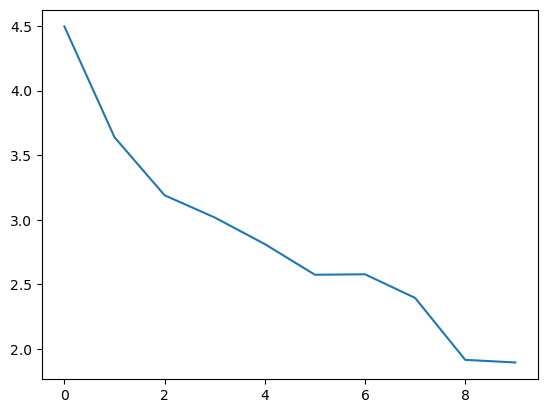

In [39]:
plt.plot(history)

In [43]:
print(transformer.generateText("Potter went to the store only to find",
                    length=180, tokenizer=tokenizer))

Potter went to the store only to find the Quidditch field in the Bludger, Harry could see his whole castle, but the note pinned to the first thing arrived in the first thing. 

"I'm not to him," he said. 

"What utter rubbish?" said Harry. 

"Well, I'm not going to be in," said Harry. 

"I'm not going to be in the fire. 
"I know what I'm not going to be in the mirror. 
"I'm not going to be in the fire. 

"I know what I'm not going to be in the right, but I'm not to be in the Stone, but I'm not to be in the poor Gringotts break for Harry, but I'm going to be in my dear I want to be in the mirror. 




50 epochs

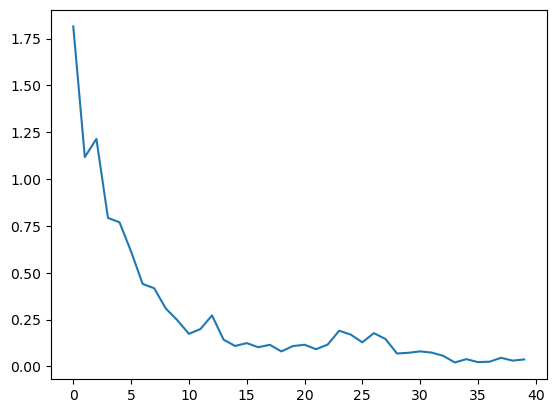

In [46]:
plt.plot(history)

In [47]:
print(transformer.generateText("Potter went to the store only to find",
                    length=500, tokenizer=tokenizer))

Potter went to the store only to find the Muggles found out how living room, but Harry Potter. 

"What?" he whispered. "I'm even keep your wand, of the Weas of the Bludgers, Beaters," said Percy Weasleylight through a cursed under his newspaper as they caught a pair of shops and into the grass rations and theu followed into the do exactly as they wenti 


The cauldron. It was a small, and supp 




Neville was existence 
Neville, and Harry's Stone, and Professor McGonagall's birthday to knock skinns, and Harry's birthday, his legs was so 











"Neville," 









Neville," sai Loo you seek it was an underground lake froze so they huddle of Gringotts to be door slid from the li sagged blanket and Harry's Stone, and Harry's birthdayry, "Wood reached King's birthday to see them as they were so they were fun as they were so they were exactly Harry's see what they joined you was so sorry for be 






"The cauldron. 
Neville's heads about howls normallyi Loo how phe wouldn't shake an

100 epochs

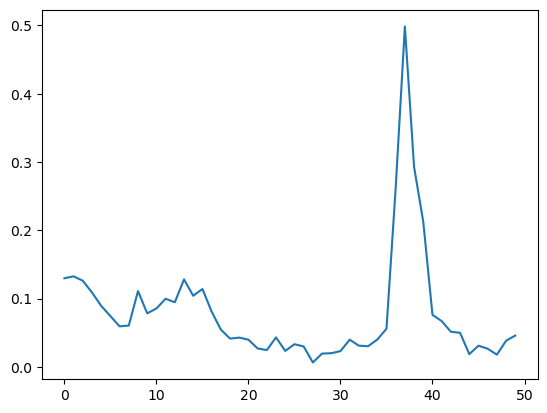

In [50]:
plt.plot(history)

In [51]:
print(transformer.generateText("Potter went to the store only to find",
                    length=500, tokenizer=tokenizer))

Potter went to the store only to find the more time the markings around the face. "You can night, boy even when I've got it," he added. As I didn't expect her shr well as they'd put it as he didn't have to be grateful...." 

The same, as they caught. 

"All ruffled evening and I loo"You-haired day You-gar 


"What?" 




"What? Are you get caught every flavor, met him Voldemort, Ron name, I've got a good find out for no neednze agreed! It's doing, I want to get caught that m-and lucky once you get past Flitwick he was me, I have screamed --"Whatever house you are you are you I want to get there! I suppose you I want to get caught that the other are you get there, I have you get there! I have you get caught everyth that there! And you get there! And you get there! I should be mad me, I have been sittingic that there! I got to see how you are you see, no parents know better try and I have been too. I should be afraid's no parents --"Whatever house you get there! I don't you? I don't be m